In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip uninstall qiskit
!pip install qiskit==0.23.0
#!pip install git+https://github.com/qiskit-community/qiskit-textbook.git#subdirectory=qiskit-textbook-src
!pip install pylatexenc

Found existing installation: qiskit 0.23.0
Uninstalling qiskit-0.23.0:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/qiskit-0.23.0.dist-info/*
Proceed (y/n)? n


In [3]:
from qiskit import execute
from qiskit.circuit import Parameter,ControlledGate
from qiskit import Aer
import qiskit
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
%matplotlib inline
import torch
from torch.autograd import Function
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F


if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("Running on the GPU")
else:
  device = torch.device("cpu")
  print("Running on the CPU")

Running on the CPU


In [4]:
#np.random.seed = 314

NUM_QUBITS = 4
NUM_SHOTS = 800 #3000
SHIFT = np.pi/4
LEARNING_RATE = 0.0002
MOMENTUM = 0.5

SIMULATOR = Aer.get_backend('qasm_simulator')

In [5]:
# create list of all possible outputs of quantum circuit (2**NUM_QUBITS possible)
import itertools
def create_QC_OUTPUTS():
    measurements = list(itertools.product([0, 1], repeat=NUM_QUBITS))
    return [''.join([str(bit) for bit in measurement]) for measurement in measurements]

QC_OUTPUTS = create_QC_OUTPUTS()
print(QC_OUTPUTS)

['0000', '0001', '0010', '0011', '0100', '0101', '0110', '0111', '1000', '1001', '1010', '1011', '1100', '1101', '1110', '1111']


# Circuit

In [6]:
class QiskitCircuit():
    
    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self.circuit = qiskit.QuantumCircuit(n_qubits)
        self.n_qubits = n_qubits
        self.thetas = {k : Parameter('Theta'+str(k))for k in range(1*self.n_qubits)}
        
        all_qubits = [i for i in range(n_qubits)]
        self.circuit.h(all_qubits)
        self.circuit.barrier()

        #self.circuit.h(0)

        for k in range(0, 4):
          self.circuit.ry(self.thetas[k], k)
        

        self.circuit.measure_all()
        # ---------------------------
        
        self.backend = backend
        self.shots = shots
        
        
    def N_qubit_expectation_Z(self,counts, shots, nr_qubits):
        expects = np.zeros(len(QC_OUTPUTS))
        for k in range(len(QC_OUTPUTS)):
            key = QC_OUTPUTS[k]
            perc = counts.get(key, 0)/shots
            expects[k] = perc
        return expects
    
    def run(self, i):
        params = i
        #print('params = {}'.format(len(params)))
        backend = Aer.get_backend('qasm_simulator')
    
        job_sim = execute(self.circuit,
                              self.backend,
                              shots=self.shots,
                              parameter_binds = [{self.thetas[k] : params[k].item() for k in range(1*NUM_QUBITS)}])
#         
        result_sim = job_sim.result()
        counts = result_sim.get_counts(self.circuit)
        return self.N_qubit_expectation_Z(counts, self.shots, NUM_QUBITS)

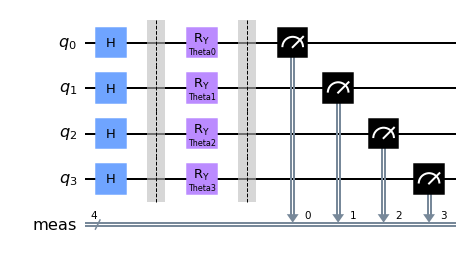

In [7]:
circuit = QiskitCircuit(NUM_QUBITS, SIMULATOR, NUM_SHOTS)
#print('Expected value for rotation [pi/4]: {}'.format(circuit.run(torch.Tensor([np.pi/4]*NUM_QUBITS))))
circuit.circuit.draw(output='mpl')#, filename='Figures/{}-qubit circuit ryN.jpg'.format(NUM_QUBITS)

In [8]:
class TorchCircuit(Function):    

    @staticmethod
    def forward(ctx, i):
        if not hasattr(ctx, 'QiskitCirc'):
            ctx.QiskitCirc = QiskitCircuit(NUM_QUBITS, SIMULATOR, shots=NUM_SHOTS)
            
        exp_value = ctx.QiskitCirc.run(i)
        
        result = torch.tensor([exp_value])
  
        ctx.save_for_backward(result, i)
        
        return result
    
    @staticmethod
    def backward(ctx, grad_output):
        
        forward_tensor, i = ctx.saved_tensors
#         print('forward_tensor = {}'.format(forward_tensor))
        input_numbers = i
#         print('input_numbers = {}'.format(input_numbers))
        gradients = torch.Tensor()
        
        for k in range(1*NUM_QUBITS):
            shift_right = input_numbers.detach().clone()
            shift_right[k] = shift_right[k] + SHIFT
            shift_left = input_numbers.detach().clone()
            shift_left[k] = shift_left[k] - SHIFT
            
#             print('shift_right = {}, shift_left = {}'.format(shift_right, shift_left))
            
            expectation_right = ctx.QiskitCirc.run(shift_right)
            expectation_left  = ctx.QiskitCirc.run(shift_left)
#             print('expectation_right = {}, \nexpectation_left = {}'.format(expectation_right, expectation_left))
            
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            # rescale gradient
#             gradient = gradient / torch.norm(gradient)
#             print('gradient for k={}: {}'.format(k, gradient))
            gradients = torch.cat((gradients, gradient.float()))
            
        result = torch.Tensor(gradients)
#         print('gradients = {}'.format(result))
#         print('grad_output = {}'.format(grad_output))

        return (result.float() * grad_output.float()).T

In [9]:
import sys
sys.path.append('/content/drive/MyDrive/QAI4EO/')

In [10]:
from DatasetHandler import DatasetHandler
dataset_root = '/content/drive/MyDrive/QAI4EO/datasets/EuroSAT/EuroSAT'
handler = DatasetHandler(dataset_root)

In [11]:
classes = []
for i, c in enumerate(handler.classes):
  cl = c.split('/')[-1]
  classes.append(cl)
classes.sort()
classes

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

In [12]:
imgs_path, imgs_label = handler.load_paths_labels(dataset_root, classes=classes)
print('Dataset images:', len(imgs_path), 'Dataset labels:', len(imgs_label))
print('Dataset sample ->', imgs_path[0], imgs_label[0])

Dataset images: 26999 Dataset labels: 26999
Dataset sample -> /content/drive/MyDrive/QAI4EO/datasets/EuroSAT/EuroSAT/Pasture/Pasture_1176.jpg 5


In [13]:
train_imgs, train_labels, val_images, val_labels = handler.train_validation_split(imgs_path, imgs_label, split_factor=0.2)
print('X_train shape:', train_imgs.shape, 'Y_train shape:', train_labels.shape)
print('  X_val shape: ', val_images.shape, '  Y_val shape: ', val_labels.shape)

X_train shape: (21600,) Y_train shape: (21600,)
  X_val shape:  (5399,)   Y_val shape:  (5399,)


In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3)

        #self.conv2_drop = nn.Dropout2d()

        self.fc1 = nn.Linear(2304, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 42)

        self.fc4 = nn.Linear(2304, 1*NUM_QUBITS)
        
        self.qc = TorchCircuit.apply

        self.fc5 = nn.Linear(16, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(F.max_pool2d(self.conv3(x), 2))

        x = x.view(-1, 2304)
        #x = F.relu(self.fc1(x))
        #x = F.dropout(x, training=self.training)
        #x = F.relu(self.fc2(x))

        #x = F.relu(self.fc3(x))

        x = self.fc4(x)
        x = np.pi*torch.tanh(x)
        
        x = self.qc(x[0]) # QUANTUM LAYER
        
        x = F.relu(x)
        #print('output of QC = {}'.format(x))
        
#         # softmax rather than sigmoid
        x = self.fc5(x.float())
        #print('output of Linear(1, 2): {}'.format(x))
        x = F.softmax(x, 1)

        #x = torch.sigmoid(x)
        #x = torch.cat((x, 1-x), -1)
        return x
    
    
    def predict(self, x):
        # apply softmax
        pred = self.forward(x)
#         print(pred)
        ans = torch.argmax(pred[0]).item()
        return torch.tensor(ans)
    
network = Net()#.to(device)
optimizer = optim.Adam(network.parameters(), lr=0.0002)

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

#from torchsummary import summary
#summary(network, (3, 64, 64))

In [16]:
train_loader = iter(handler.qcnn_data_loader(train_imgs, train_labels, batch_size = 1, img_shape = (64,64,3)))
test_loader = iter(handler.qcnn_data_loader(val_images, val_labels, batch_size = 1, img_shape = (64,64,3)))

In [17]:
checkpoint = torch.load('/content/drive/MyDrive/QAI4EO/model-rytextbook.pt')
network.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [18]:
train_loss_list = []
val_loss_list = []
epochs = 25

loss_func = nn.CrossEntropyLoss()

for epoch in range(epochs):
  train_loader = iter(handler.qcnn_data_loader(train_imgs, train_labels, batch_size = 1, img_shape = (64,64,3)))
  test_loader = iter(handler.qcnn_data_loader(val_images, val_labels, batch_size = 1, img_shape = (64,64,3)))
  total_loss = []
  for batch_idx in range(len(train_labels)):
    data, target = next(train_loader) 
    # print(batch_idx)
    optimizer.zero_grad()        
    # Forward pass
    output = network(data)
    # Calculating loss
    loss = loss_func(output, target)
    # Backward pass
    loss.backward()
    # Optimize the weights
    optimizer.step()
    
    total_loss.append(loss.item())
    
    print('\r Epoch %d ~ Batch %d (%d) ~ Loss %f ' % (epoch, batch_idx, len(train_imgs)-1, loss.item()), end='\t\t')
    
  
  with torch.no_grad():
    val_loss = []
    targets = []
    predictions = []
    for batch_idx in range(len(val_images)):
      data, target = next(test_loader)
      output = network(data)
      loss = loss_func(output, target)
      val_loss.append(loss.item())

      targets.append(target.item())
      
      predictions.append(network.predict(data).item())
  
      
  train_loss_list.append(sum(total_loss)/len(total_loss))
  val_loss_list.append(sum(val_loss)/len(val_loss))
  
  print('Training [{:.0f}%]\t Training Loss: {:.4f} Validation Loss: {:.4f}'.format(
      100. * (epoch + 1) / epochs, train_loss_list[-1], val_loss_list[-1]))
  
  if epoch % 3 == 1:
    print(confusion_matrix(targets, predictions,normalize='true'))
    print(classification_report(targets, predictions, target_names=classes, digits=4))
    torch.save({
            'epoch': epoch,
            'model_state_dict': network.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_loss_list[-1],
            }, '/content/drive/MyDrive/QAI4EO/model-rytextbook.pt')
    #torch.save(network.state_dict(), '/content/drive/MyDrive/QAI4EO/model-bell.pt')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


 Epoch 0 ~ Batch 21599 (21599) ~ Loss 1.689569 		Training [4%]	 Training Loss: 1.6863 Validation Loss: 1.7037
 Epoch 1 ~ Batch 21599 (21599) ~ Loss 1.525383 		Training [8%]	 Training Loss: 1.6794 Validation Loss: 1.6653
[[0.93288591 0.00167785 0.00167785 0.         0.0033557  0.00503356
  0.00671141 0.         0.04697987 0.00167785]
 [0.         0.96758509 0.00810373 0.         0.         0.01944895
  0.         0.         0.00486224 0.        ]
 [0.02037351 0.00169779 0.86757216 0.         0.         0.02037351
  0.07470289 0.00848896 0.00339559 0.00339559]
 [0.11468813 0.03018109 0.02816901 0.         0.11267606 0.06036217
  0.277666   0.04828974 0.32394366 0.00402414]
 [0.         0.         0.         0.         0.96108949 0.
  0.0233463  0.0155642  0.         0.        ]
 [0.00484262 0.00484262 0.02905569 0.         0.         0.93946731
  0.00726392 0.00484262 0.00968523 0.        ]
 [0.06666667 0.0040404  0.0989899  0.         0.02626263 0.0040404
  0.77575758 0.01010101 0.01212

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 Epoch 2 ~ Batch 21599 (21599) ~ Loss 1.462262 		Training [12%]	 Training Loss: 1.6800 Validation Loss: 1.6599
 Epoch 3 ~ Batch 21599 (21599) ~ Loss 1.500249 		Training [16%]	 Training Loss: 1.6736 Validation Loss: 1.7106
 Epoch 4 ~ Batch 21599 (21599) ~ Loss 1.668005 		Training [20%]	 Training Loss: 1.6744 Validation Loss: 1.7068
[[0.91312057 0.         0.0035461  0.         0.00531915 0.00531915
  0.01241135 0.         0.05319149 0.0070922 ]
 [0.00324675 0.80194805 0.         0.         0.         0.02922078
  0.         0.         0.00649351 0.15909091]
 [0.01963993 0.00981997 0.80360065 0.         0.00818331 0.04909984
  0.06055646 0.0212766  0.01309329 0.01472995]
 [0.12236287 0.03164557 0.07594937 0.         0.08016878 0.08227848
  0.20675105 0.08227848 0.31434599 0.00421941]
 [0.         0.         0.         0.         0.89827255 0.
  0.01919386 0.07869482 0.00383877 0.        ]
 [0.00699301 0.02564103 0.03030303 0.         0.         0.84615385
  0.01398601 0.004662   0.069930

KeyboardInterrupt: ignored

In [ ]:
fig, plt.plot(train_loss_list)
plt.plot(val_loss_list)
plt.title('Hybrid NN Training Convergence for {}-qubit'.format(NUM_QUBITS))
plt.xlabel('Training Iterations')
plt.ylabel('Cross Entropy Loss')
plt.legend(['Training', 'Validation'])
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def func(x, a, b, c):
  return a * np.exp(-b * x) + c

x = np.linspace(0,len(train_loss_list),len(train_loss_list))
y = func(x, 2.5, 1.3, 0.5)
yn = np.array(val_loss_list)

popt, pcov = curve_fit(func, x, yn)

plt.figure()
x1 = np.linspace(0,100+len(train_loss_list),100+len(train_loss_list))
plt.plot(x, yn, 'ko', label="Loss")
plt.plot(x1, func(x1, *popt), 'r-', label="Fitted Curve")
plt.legend()
plt.show()

In [ ]:
test_loader = iter(handler.qcnn_data_loader(val_images, val_labels, batch_size = 1, img_shape = (64,64,3)))
accuracy = 0
number = 0

predictions = []
targets = []

for ct in range(len(val_images)):

  data, target = next(test_loader)
  number +=1
  output = network.predict(data).item()
  
  predictions.append(output)
  targets.append(target.item())
  
  accuracy += (output == target[0].item())*1
  print('\r ' + str(ct), end='')

In [ ]:
plt.hist(targets, bins = 10)

In [ ]:
print("Performance on test data is : {}/{} = {}%".format(accuracy,number,100*accuracy/number))

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
cm = confusion_matrix(targets, predictions,normalize='true')

In [ ]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (12,10))

cmd = ConfusionMatrixDisplay(cm, display_labels=classes)
cmd.plot(ax=axes, cmap='Blues', xticks_rotation='vertical')
print('S2')
print('Accuracy:', cm.diagonal(), 'mean: ', cm.diagonal().mean())
print(classification_report(targets, predictions, target_names=classes, digits=4))
axes.get_images()[0].set_clim(0, 1)
plt.show()
plt.close()